In [1]:
%matplotlib inline

import sys

sys.path.append("..")

In [2]:
import torch
torch.cuda._lazy_init() # avoid "Unknown CUDA error"
print("torch.cuda.is_available()   =", torch.cuda.is_available())
print("torch.cuda.device_count()   =", torch.cuda.device_count())
print("torch.cuda.device('cuda')   =", torch.cuda.device('cuda'))
print("torch.cuda.current_device() =", torch.cuda.current_device())

torch.cuda.is_available()   = True
torch.cuda.device_count()   = 1
torch.cuda.device('cuda')   = <torch.cuda.device object at 0x0000027574BDD828>
torch.cuda.current_device() = 0


# Image classification

I will write a simple classifier for sketchy images to use as a benchmark for other methods.

In [3]:
# Load the Dataset class

from settings import DATA_SOURCES
from src.datasets.sketchy import Sketchy

dataset = Sketchy(DATA_SOURCES['sketchy_test']['photos'])
len(dataset)

1250

In [4]:
import torch

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 8

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

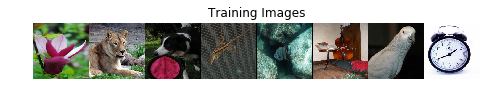

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Create the dataloader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Plot some training images
real_batch = next(iter(data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
real_batch[0].size()

torch.Size([8, 3, 256, 256])

In [7]:
from src.models.convolutional.classification import ClassificationConvolutionalNetwork as ConvolutionalNetwork

net = ConvolutionalNetwork()
net.to(device)
print(net)

# Define optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

ClassificationConvolutionalNetwork(
  (convolution_1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (convolution_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (convolution_3): Conv2d(16, 20, kernel_size=(4, 4), stride=(1, 1))
  (fully_connected_1): Linear(in_features=16820, out_features=15000, bias=True)
  (fully_connected_2): Linear(in_features=15000, out_features=1200, bias=True)
  (fully_connected_3): Linear(in_features=1200, out_features=125, bias=True)
)


In [8]:
len(data_loader)

157

In [9]:
epochs = 2

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(data_loader, 0):
        # get the inputs
        inputs, labels = data

        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 5 == 4:  # print every 5 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 5))
            running_loss = 0.0

[1,     5] loss: 4.833
[1,    10] loss: 4.828
[1,    15] loss: 4.830
[1,    20] loss: 4.824
[1,    25] loss: 4.832
[1,    30] loss: 4.835
[1,    35] loss: 4.828
[1,    40] loss: 4.833
[1,    45] loss: 4.832
[1,    50] loss: 4.833
[1,    55] loss: 4.833
[1,    60] loss: 4.829
[1,    65] loss: 4.824
[1,    70] loss: 4.829
[1,    75] loss: 4.829
[1,    80] loss: 4.826
[1,    85] loss: 4.828
[1,    90] loss: 4.833
[1,    95] loss: 4.832
[1,   100] loss: 4.828
[1,   105] loss: 4.830
[1,   110] loss: 4.829
[1,   115] loss: 4.830
[1,   120] loss: 4.829
[1,   125] loss: 4.827
[1,   130] loss: 4.837
[1,   135] loss: 4.833
[1,   140] loss: 4.831
[1,   145] loss: 4.828
[1,   150] loss: 4.832
[1,   155] loss: 4.834
[2,     5] loss: 4.826
[2,    10] loss: 4.832
[2,    15] loss: 4.831
[2,    20] loss: 4.825
[2,    25] loss: 4.830
[2,    30] loss: 4.824
[2,    35] loss: 4.822
[2,    40] loss: 4.824
[2,    45] loss: 4.824
[2,    50] loss: 4.834
[2,    55] loss: 4.825
[2,    60] loss: 4.830
[2,    65] 